In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from Utilities.basic_units import radians
from src import orbits as orb
from Utilities import sections as sec

from Utilities.operators import make_tree, Ryan_sampler, to_cylindric
from Utilities.time_extractor import days_since_distruption
matplotlib.rcParams['figure.dpi'] = 150

<Figure size 800x600 with 0 Axes>

In [2]:
G = 1
m = 4
Mbh = 10**m
beta = 1
mstar = .5
Rstar = .47
n = 1.5
check = 'Low' # '' or 'HiRes' or 'Res20'
folder = f'R{Rstar}M{mstar}BH{Mbh}beta{beta}S60n{n}'
snap = '164'
path = f'TDE/{folder}{check}/{snap}'
saving_path = f'Figs/{folder}/{check}'
print(f'We are in: {path}, \nWe save in: {saving_path}')
is_tde = True
threshold=1/3

Rt = Rstar * (Mbh/mstar)**(1/3)
Rp =  Rt / beta
R0 = 0.6 * Rp
apo = Rt**2 / Rstar #2 * Rt * (Mbh/mstar)**(1/3)

G_SI = 6.6743e-11
Msol = 2e30 #1.98847e30 # kg
Rsol = 7e8 #6.957e8 # m
t = np.sqrt(Rsol**3 / (Msol*G_SI ))
c = 3e8 / (7e8/t)

Rs = 2*G*Mbh / c**2

# cfr tidal disruption and at smoothing lenght
xcfr, ycfr, cfr = orb.make_cfr(Rt)
xcfr0, ycfr0, cfr0 = orb.make_cfr(R0)

We are in: TDE/R0.47M0.5BH10000beta1S60n1.5Low/164, 
We save in: Figs/R0.47M0.5BH10000beta1S60n1.5/Low


Load data

In [3]:
# sim_tree, X, Y, Z, Vol, VX, VY, VZ, Den, Press, Temp, IE, Diss, Entropy = make_tree(path, snap, is_tde, energy = True)
data = make_tree(path, snap, is_tde, energy = False)
density = np.load(f'TDE/{folder}{check}/{snap}/smoothed_Den_{snap}.npy') # data.Den

# div = np.load(f'{folder}/{snap}/DivV_{snap}.npy')
# shockzone = np.loadtxt(f'data/{snap}/shockzone_{snap}.txt')
# shocksurface = np.loadtxt(f'data/{snap}/shocksurface_{snap}.txt')

R = np.sqrt(data.X**2 + data.Y**2 + data.Z**2)
THETA, RADIUS_cyl = to_cylindric(data.X, data.Y)
V = np.sqrt(data.VX**2 + data.VY**2 + data.VZ**2)
Vcyl = np.sqrt(data.VX**2 + data.VY**2)
orb_en = orb.orbital_energy(RADIUS_cyl, Vcyl, G, Mbh)
dim_cell = data.Vol**(1/3) 

tfb = days_since_distruption(f'{path}/snap_{snap}.h5', m, mstar, Rstar, choose = 'tfb')

# Shock zone
# idx_zone = shockzone[0]
# idx_zone = np.array([int(i) for i in idx_zone])
# x_zone = X[idx_zone]
# y_zone = Y[idx_zone]
# z_zone = Z[idx_zone]
# Vx_zone = VX[idx_zone]
# Vy_zone = VY[idx_zone]
# Vz_zone = VZ[idx_zone]
# Diss_zone = Diss[idx_zone]
# dim_cell_zone = dim_cell[idx_zone]
# div_zone = div[idx_zone]

# Shock surface
# idx_surf = shocksurface[0]
# idx_surf = np.array([int(i) for i in idx_surf])
# x_surf = x_zone[idx_surf]
# y_surf = y_zone[idx_surf]
# z_surf = z_zone[idx_surf]
# Vx_surf = Vx_zone[idx_surf]
# Vy_surf = Vy_zone[idx_surf]
# dim_cell_surf = dim_cell_zone[idx_surf]
# div_surf = div_zone[idx_surf]

days after disruption: 1.3532153925058021 // t_fall: 2.5777261297507925 // sim_time: 73.40236449912129


Midplane 

In [4]:
midplane = np.abs(data.Z) < dim_cell
X_midplane, Y_midplane, Z_midplane, dim_midplane, Mass_midplane, Den_midplane, Temp_midplane, = \
    sec.make_slices([data.X, data.Y, data.Z, dim_cell, data.Mass, density, data.Temp], midplane)

Text(0.5, 1.0, 'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = 0.525')

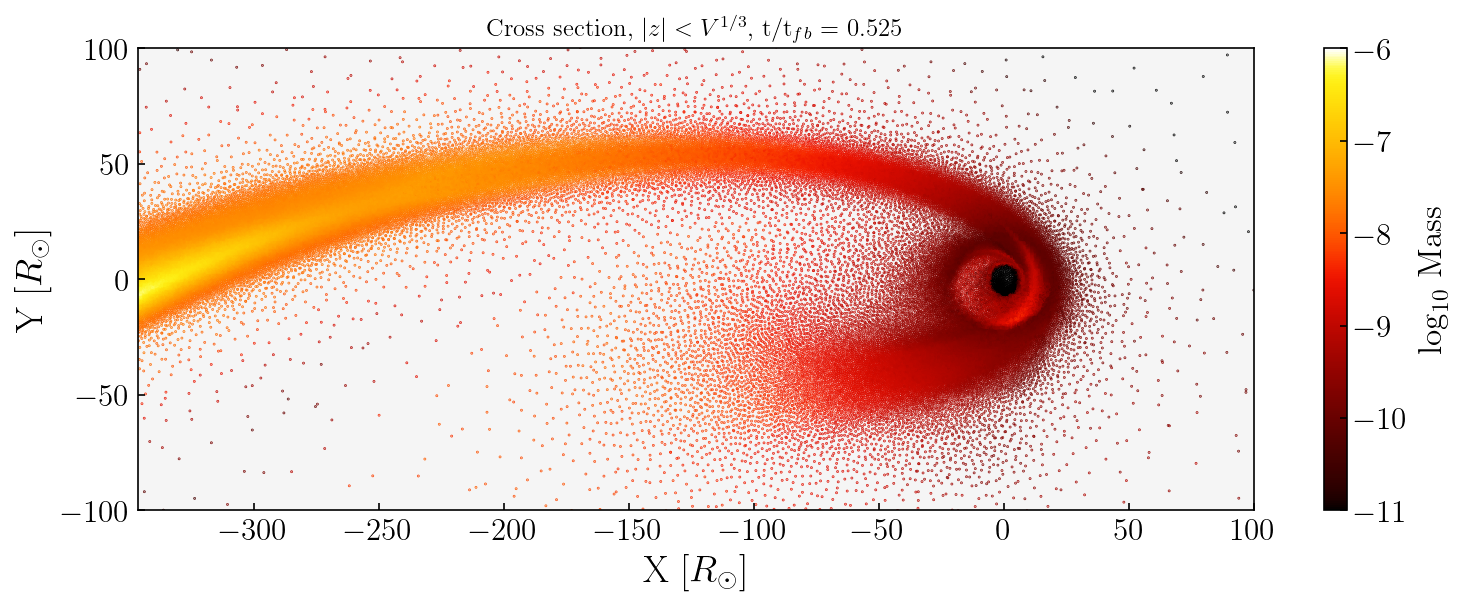

In [17]:
fig, ax = plt.subplots(1,1, figsize = (12,4))
img = ax.scatter(X_midplane, Y_midplane, c = np.log10(Mass_midplane), s = .1, cmap = 'cet_fire', vmin = -11, vmax = -6)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Mass', fontsize = 16)
ax.set_xlim(-50,100)
ax.set_ylim(20,40)
ax.set_xlim(-apo,100)
ax.set_ylim(-100,100)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))


In [6]:
# fig, ax = plt.subplots(1,2, figsize = (12,5))
# img = ax[0].scatter(X_midplane, Y_midplane, c = np.log10(Den_midplane), s = 0.1, cmap = 'viridis', vmin = -8, vmax = -7)
# ax[0].contour(xcfr, ycfr, cfr, [0], linestyles = 'dotted', colors = 'k')
# ax[0].contour(xcfr0, ycfr0, cfr0, [0], linestyles = 'dotted', colors = 'k')
# #ax[0].contour(xcftest, ycftest, cftest, [0], linestyles = 'dotted', colors = 'b')
# cbar = plt.colorbar(img)
# cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
# ax[0].set_xlim(-20,20)
# ax[0].set_ylim(-20,20)
# ax[0].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
# ax[0].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

# img1 = ax[1].scatter(X_midplane, Y_midplane, c = np.log10(Temp_midplane), marker= 's', s = 0.1, cmap = 'viridis', vmin = 5.4, vmax = 6.4)
# cbar1 = plt.colorbar(img1)#, format='%.0e')
# cbar1.set_label(r'$\log_{10}$ Temperature', fontsize = 16)
# #ax[1].quiver(X_midplane[::200], Y_midplane[::200], VX_midplane[::200], VY_midplane[::200], color = 'k', angles='xy', scale_units='xy', width = 1e-3, scale = 10)
# ax[1].set_xlim(-20,20)
# ax[1].set_ylim(-20, 20)
# ax[1].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
# plt.suptitle(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)) + f', check: {check}')

# plt.tight_layout()
# #plt.savefig(f'{saving_path}/xy{snap}.png')

Tangent and transverse plane

In [7]:
theta_lim = np.pi
step = 0.02
theta_init = np.arange(-theta_lim, theta_lim, step)
theta_arr = Ryan_sampler(theta_init)

In [9]:
x_orbit, y_orbit, z_orbit = orb.find_transverse_maximum(data.X, data.Y, data.Z, dim_cell, density, theta_arr, Rt)
condition_tra, x_onplane, x0 = sec.transverse_plane(data.X, data.Y, dim_cell, x_orbit, y_orbit, 98, coord= True)

(-475.0, 475.0)

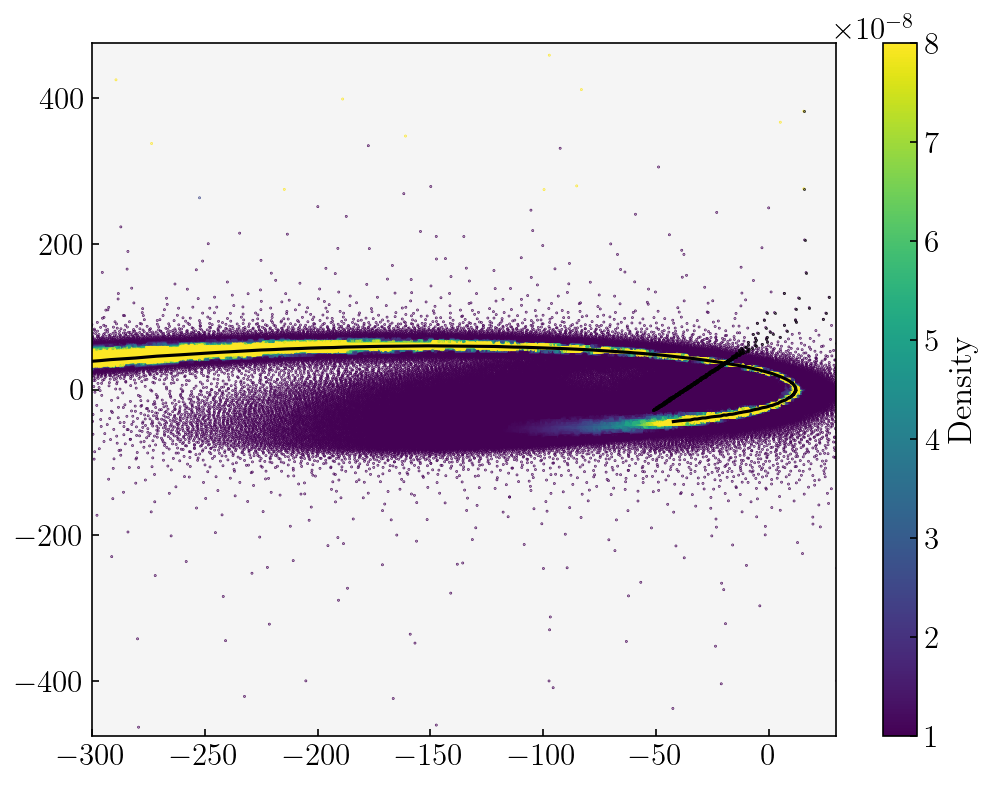

In [11]:
X_tra, Y_tra, Z_tra, Den_tra, RADIUS_cyl_tra = \
    sec.make_slices([data.X, data.Y, data.Z, density, RADIUS_cyl], condition_tra)
X_tra_midplane = X_tra[np.abs(Z_tra) < dim_cell[condition_tra]]
Y_tra_midplane = Y_tra[np.abs(Z_tra) < dim_cell[condition_tra]]
img = plt.scatter(X_midplane, Y_midplane, c = Den_midplane, s = .1, cmap = 'viridis', vmin = 1e-8, vmax = 8e-8)
cbar = plt.colorbar(img)
cbar.set_label(r' Density', fontsize = 16)
plt.plot(x_orbit[30:230], y_orbit[30:230], c = 'k')
# plt.contour(xcfr, ycfr, cfr, [0], linestyles = 'dotted', colors = 'k')
plt.scatter(X_tra_midplane, Y_tra_midplane, s = 0.1, c = 'k')
# plt.scatter(x_chosen, y_chosen, marker = 'x', s = 27, c = 'b')
plt.xlim(-300,30)
plt.ylim(-475,475)


In [ ]:
cm, lower_tube_w, upper_tube_w, lower_tube_h, upper_tube_h, w_params, h_params  = orb.follow_the_stream(data.X, data.Y, data.Z, dim_cell, density, theta_arr, Rt, threshold=threshold)

In [ ]:
# np.save(f'data/{folder}/2DALLavgstream_{check}{snap}_{step}.npy', [theta_arr, cm[:,0], cm[:,2], cm[:,3]])

In [ ]:
# cm_init, lower_tube_w_init, upper_tube_w_init, lower_tube_h_init, upper_tube_h_init, w_params_init, h_params_init  = orb.follow_the_stream(data.X, data.Y, data.Z, dim_cell, density, theta_init, Rt, threshold=threshold)
# plt.scatter(cm[:,0], cm[:,2], s= 5, c = 'k', label = r'$\theta$ to $\pi\tanh(2\theta/\pi)/tanh(2)$')
# plt.scatter(cm_init[:,0], cm_init[:,2], s = 1, c = 'r', label = r'sample $\theta$')
# plt.scatter(cm[50,0], cm[50,2], s = 120, marker = '+', c = 'b')
# plt.scatter(cm_init[50,0], cm_init[50,2], s = 120, marker = '+', c = 'orange')
# plt.xlim(-400,30)
# plt.ylim(-75,75)
# plt.title(r'Idx 50 for $\theta$')
# plt.legend()

In [ ]:
idx = 80
theta_chosen = theta_arr[idx]
x_chosen, y_chosen = cm[idx][0], cm[idx][2]
radius_chosen = np.sqrt(x_chosen**2 + y_chosen**2)

condition_tra, x_onplane, x0 = sec.transverse_plane(data.X, data.Y, dim_cell, cm[:,0], cm[:,2], idx, coord= True)
X_tra, Y_tra, Z_tra, Den_tra, RADIUS_cyl_tra = \
    sec.make_slices([data.X, data.Y, data.Z, density, RADIUS_cyl], condition_tra)
X_tra_midplane = X_tra[np.abs(Z_tra) < dim_cell[condition_tra]]
Y_tra_midplane = Y_tra[np.abs(Z_tra) < dim_cell[condition_tra]]
x_onplane_midplane = x_onplane[np.abs(Z_tra) < dim_cell[condition_tra]]

condition_tg = sec.tangent_plane(data.X, data.Y, dim_cell, cm[:,0], cm[:,1], idx)
X_tg, Y_tg, Z_tg, Den_tg, RADIUS_cyl_tg = \
    sec.make_slices([data.X, data.Y, data.Z, density, RADIUS_cyl], condition_tg)
X_tg_midplane = X_tg[np.abs(Z_tg) < dim_cell[condition_tg]]
Y_tg_midplane = Y_tg[np.abs(Z_tg) < dim_cell[condition_tg]]

vmaxrho = 2e-7
vminrho = threshold*vmaxrho
fig, ax = plt.subplots(1,2, figsize = (14,5),  gridspec_kw={'width_ratios': [1.8, 1]})
img0 = ax[0].scatter(X_midplane, Y_midplane, c = Den_midplane, s = .1, cmap = 'viridis', vmin = vminrho, vmax = vmaxrho)
cbar = plt.colorbar(img0, location="top", fraction=0.08)
cbar.set_label(r'Density', fontsize = 14)
ax[0].scatter(0,0,s=40, c= 'k')
ax[0].contour(xcfr, ycfr, cfr, [0], linestyles = 'dotted', colors = 'k')
ax[0].plot(cm[:,0], cm[:,2], c = 'k')
ax[0].scatter(X_tra_midplane, Y_tra_midplane, s = 1, c = 'k')
ax[0].plot(upper_tube_w[:,0], upper_tube_w[:,2], linestyle = 'dotted', c = 'k')
ax[0].plot(lower_tube_w[:,0], lower_tube_w[:,2],  '--', c = 'k')
ax[0].set_xlim(-200,30)
ax[0].set_ylim(-60,70)
ax[0].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
# ax[0].text(-195, 70, f'Check: {check}')

img = ax[1].scatter(X_midplane, Y_midplane, c = Den_midplane, s = .1, cmap = 'viridis', vmin = vminrho, vmax = vmaxrho)
ax[1].scatter(0,0,s=40, c= 'k')
ax[1].plot(cm[:,0], cm[:,2], c = 'k')
ax[1].scatter(x_chosen, y_chosen, marker = 'x', s = 27, c = 'k')
ax[1].scatter(upper_tube_w[idx,0], upper_tube_w[idx,2], s = 27, c = 'k')
ax[1].scatter(lower_tube_w[idx,0], lower_tube_w[idx,2], s = 27, c = 'b')
ax[1].plot(upper_tube_w[:,0], upper_tube_w[:,2], linestyle = 'dotted', c = 'k')
ax[1].plot(lower_tube_w[:,0], lower_tube_w[:,2],  '--', c = 'b')
cbar = plt.colorbar(img, location="top", fraction=0.08)
cbar.set_label(r'Density', fontsize = 14)
#ax[1].scatter(x_chosen, y_chosen, marker = 'x', s = 27, c = 'b')
ax[1].set_xlim(-10,20)
ax[1].set_ylim(-15,15)
ax[1].set_xlabel(r'X [$R_\odot$]', fontsize = 18)

plt.tight_layout()
# plt.savefig(f'{saving_path}/2DALLavg_widthproj{snap}.png')


In [ ]:
plt.figure(figsize = (8,5))
img0 = plt.scatter(X_midplane, Y_midplane, c = Den_midplane, s = .1, cmap = 'viridis', vmin = vminrho, vmax = vmaxrho)
cbar = plt.colorbar(img0, location="top", fraction=0.08)
cbar.set_label(r'Density', fontsize = 14)
plt.scatter(0,0,s=40, c= 'k')
# plt.contour(xcfr, ycfr, cfr, [0], linestyles = 'dotted', colors = 'k')
plt.plot(cm[:,0], cm[:,2], c = 'k')
plt.scatter(X_tra_midplane, Y_tra_midplane, s = 1, c = 'k')
plt.plot(upper_tube_w[:,0], upper_tube_w[:,2], linestyle = 'dotted', c = 'k')
plt.plot(lower_tube_w[:,0], lower_tube_w[:,2],  '--', c = 'k')
plt.xlim(-300,30)
plt.ylim(-80,80)
plt.xlabel(r'X [$R_\odot$]', fontsize = 18)
plt.ylabel(r'Y [$R_\odot$]', fontsize = 18)

In [ ]:
vmaxrho = 5e-8
vminrho = 1/3 * vmaxrho -1e-8 # -1 to see the lower values
fig, ax = plt.subplots(1,2, figsize = (12,5))
img = ax[0].scatter(X_midplane, Y_midplane, c = Den_midplane, s = .1, cmap = 'viridis', vmin = vminrho, vmax = vmaxrho)
cbar = plt.colorbar(img)
cbar.set_label(r' Density', fontsize = 16)
#ax[0].plot(x_orbit, y_orbit, c = 'r')
ax[0].contour(xcfr, ycfr, cfr, [0], linestyles = 'dotted', colors = 'k')
ax#[0].scatter(X_tra_midplane, Y_tra_midplane, s = 0.1, c = 'k')
#ax[0].scatter(x_chosen, y_chosen, marker = 'x', s = 27, c = 'b')
ax[0].set_xlim(-100,20)
ax[0].set_ylim(-60,60)
ax[0].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

img1 = ax[1].scatter(X_midplane, Y_midplane, c = np.log10(Temp_midplane), s = .1, cmap = 'inferno', vmin = 4, vmax = 5)
cbar1 = plt.colorbar(img1)
ax[1].contour(xcfr, ycfr, cfr, [0], linestyles = 'dotted', colors = 'k')
cbar1.set_label(r'$\log_{10}$ Temperature', fontsize = 16)
ax[1].set_xlim(-200,20)
ax[1].set_ylim(-90,90)
ax[1].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[1].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

plt.suptitle(r't/t$_{fb}$ = ' + str(np.round(tfb,3)) + f', check: {check}', fontsize = 14)
plt.tight_layout()

#plt.savefig(f'Figs/{folder}/{check}/cross{snap}.png')

In [ ]:
# fig, ax = plt.subplots(1,1, figsize = (6,4))
# img = ax.scatter(X_midplane, Y_midplane, c = Diss_midplane/Vol_midplane, s = 5, cmap = 'jet', vmin = -1e-6, vmax = 1e-6)
# cbar = plt.colorbar(img)#, format='%.0e')
# cbar.set_label('energy density dissipation', fontsize = 16)
# ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='k', label = 'shock zone')
# #ax.plot(x_cross_surf, y_cross_surf, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='k', label = 'shock surface')
# ax.set_xlim(3,29)
# ax.set_ylim(-18,23)
# ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
# ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
# plt.grid()
# plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))
# plt.legend(loc = 'upper right')
# #plt.savefig('Figs/EnDisszone{snap}.png')